# Logistic Regression with a Neural Network Mindset

### I will basically follow https://github.com/Kulbear 's work on Andrew Ng's Deep Learning Specialization C1W2 homework assignment with some modification 
### I will build a logistic regression classifier to recognize cats with a NN mindset

Build the general architecture of a learning algorithm, including:
- Initializing parameters
- Calculating the cost function and its gradient
- Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order.

## 1 - Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

import cv2
import os

%matplotlib inline

## 2 - Overview of the data set

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).


In [2]:
train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
test_dataset = h5py.File('datasets/test_catvnoncat.h5', 'r')

train_dataset.keys(), test_dataset.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [3]:
train_set_x_orig = np.array(train_dataset['train_set_x'])
test_set_x_orig = np.array(test_dataset['test_set_x'])
train_set_y = np.array(train_dataset['train_set_y'])
test_set_y = np.array(test_dataset['test_set_y'])
classes = np.array(train_dataset['list_classes'])

print(train_set_x_orig.shape, train_set_y.shape) # (m, w, h, c)
print(test_set_x_orig.shape, test_set_y.shape)  # (m, ) rank 1 array
print(classes)


(209, 64, 64, 3) (209,)
(50, 64, 64, 3) (50,)
[b'non-cat' b'cat']


y = [ 1 ]
It is a  cat  picture


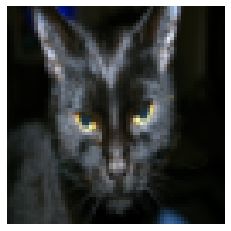

In [4]:
# display a sample image
index = 25
plt.imshow(train_set_x_orig[index])
plt.axis('off')
print('y = [', train_set_y[index], ']')
print('It is a ', classes[train_set_y[index]].decode('utf-8'), ' picture')
plt.show()

In [5]:
unique, counts = np.unique(train_set_y, return_counts=True)
unique, counts, np.count_nonzero(train_set_y == 0), np.count_nonzero(train_set_y == 1)

(array([0, 1]), array([137,  72]), 137, 72)

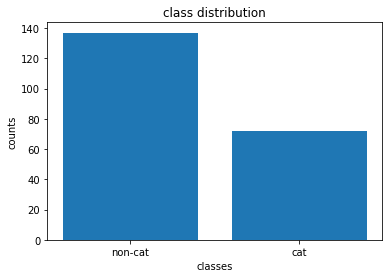

In [6]:
plt.bar(x=classes[unique], height=counts)
plt.title('class distribution')
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

### Common steps for pre-processing a new dataset are:

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1). 
- Shape of X_train shall be (num_px * num_px * 3, m_train), Shape of X_test shall be (num_px * num_px * 3, m_test)
- "Standardize" the data
- Reshape y_train to (1, m_train), y_test to (1, m_test). Avoid use rank 1 array

In [7]:
# define some variable for later use
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print('Number of train example :', m_train)
print('Number of test example :', m_test)
print('Height / Width of each image :', num_px)
print('Each image is of the size (%s, %s, 3)' %(num_px, num_px))
print('train_set_x shape:', train_set_x_orig.shape)
print('train_set_y shape:', train_set_y.shape)
print('test_set_x shape:', test_set_x_orig.shape)
print('test_set_y shape:', test_set_y.shape)


Number of train example : 209
Number of test example : 50
Height / Width of each image : 64
Each image is of the size (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


In [8]:
# reshape X to (nx, m), y to (1, m)

train_set_y = train_set_y.reshape(1, -1)
test_set_y = test_set_y.reshape(1, -1)

train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print('train_set_x_flatten shape: ', train_set_x_flatten.shape)
print('train_set_y shape: ', train_set_y.shape)
print('test_set_x_flatten shape: ', test_set_x_flatten.shape)
print('test_set_y shape: ', test_set_y.shape)

train_set_x_flatten shape:  (12288, 209)
train_set_y shape:  (1, 209)
test_set_x_flatten shape:  (12288, 50)
test_set_y shape:  (1, 50)


In [9]:
# feature scaling
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

## 3. General Architecure of the learning algorithm
### Main steps
- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

### The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
4. Calculate current loss (forward propagation)
5. Calculate current gradient (backward propagation)
6. Update parameters (gradient descent)
7. You often build 1-3 separately and integrate them into one function we call model().

### 3.1 Helper function
- Sigmoid function

In [10]:
def sigmoid (z):

    return 1 / (1 + np.exp( - np.array(z)))

In [11]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))
print ("sigmoid(9.2) = " + str(sigmoid([0, 9.2])))


sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922
sigmoid(9.2) = [0.5        0.99989897]


### 3.2 Initialize Parameters
- initialize w to be zeros (nx, 1)
- initialize b to be zero 

In [12]:
def initialize_with_zeros(dim):
    ''' dim: size of w vector ''' 
    w = np.zeros((dim, 1))
    b = 0

    assert( w.shape == (dim, 1))
    assert( isinstance(b, float) or isinstance(b, int) )
    return w, b

In [13]:
dim = 2
w, b = initialize_with_zeros(dim)
print('w = ', w)
print('b = ', b)

w =  [[0.]
 [0.]]
b =  0


### 3.3 Forward Propagation and Backward Propagation

In [14]:
def propagate (w, b, X, Y):
    
    Z = np.dot( w.T, X) + b
    A = sigmoid(Z)
    m = X.shape[1]

    cost =  (-1 / m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1 - A))

    dZ = A - Y
    dw = (1 / m) * np.dot( X, dZ.T)
    db = (1 / m) * np.sum( dZ)

    grads = {
        'dw': dw, 
        'db': db
    }
    return grads, cost



In [15]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ('grads = ', str(grads['dw']))
print ('db = ' , str(grads['db']))
print ('cost = ' , str(cost))

grads =  [[0.99993216]
 [1.99980262]]
db =  0.49993523062470574
cost =  6.000064773192205


#### 3.4 Optimization

In [16]:
def optimize (w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate( w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i%100 == 0:
            costs.append(cost)
        if print_cost and i%100 == 0:
            print('Cost at %s iteration:  %s'%(i, cost)) 
    
    params = {'w': w, 'b' :b}
    grads = {'dw' : dw, 'db': db}
    return params, grads, costs
           

In [17]:

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print('costs = ' , costs)

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
costs =  [6.000064773192205]


### 3.5 Predict

In [18]:
def predict (w, b, X):

    m = X.shape[1]
    Z = np.dot( w.T, X) + b
    A = sigmoid(Z)

    y_pred = np.zeros((1, m))

    y_pred[A >= 0.5] = 1
    #y_pred[A < 0.5] =0
    return y_pred
     

In [19]:
print("predictions = " + str(predict(w, b, X)))


predictions = [[1. 1.]]


## 4 Merge all function into a model

In [20]:
def model (X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost=False):
    
    nx = X_train.shape[0]
    w, b =  initialize_with_zeros(nx)

    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    Y_pred_test = predict(w, b , X_test)
    Y_pred_train = predict(w, b , X_train)
    
    unique, counts = np.unique(np.equal(Y_pred_test, Y_test), return_counts=True)
    #print('test accuracy:%s percent'%(counts[1]/ np.sum(counts) *100) )

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_pred_test, 
         "Y_prediction_train" : Y_pred_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [21]:

#print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost at 0 iteration:  0.6931471805599453
Cost at 100 iteration:  0.5845083636993085
Cost at 200 iteration:  0.4669490409465547
Cost at 300 iteration:  0.37600686694802077
Cost at 400 iteration:  0.3314632893282512
Cost at 500 iteration:  0.303273067474383
Cost at 600 iteration:  0.27987958658260487
Cost at 700 iteration:  0.2600421369258757
Cost at 800 iteration:  0.2429406846779662
Cost at 900 iteration:  0.22800422256726066
Cost at 1000 iteration:  0.2148195137844964
Cost at 1100 iteration:  0.20307819060644985
Cost at 1200 iteration:  0.1925442771670686
Cost at 1300 iteration:  0.18303333796883509
Cost at 1400 iteration:  0.17439859438448876
Cost at 1500 iteration:  0.16652139705400335
Cost at 1600 iteration:  0.15930451829756614
Cost at 1700 iteration:  0.152667324712965
Cost at 1800 iteration:  0.1465422350398234
Cost at 1900 iteration:  0.14087207570310162
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


### 4.1 Plot learning curve

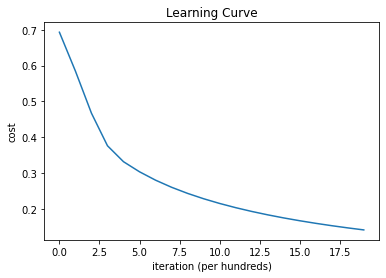

In [22]:
plt.plot(d['costs'])
plt.title('Learning Curve')
plt.xlabel('iteration (per hundreds)')
plt.ylabel('cost')
plt.show()

## 5. Tune Learning Rate

In [23]:
learning_rates = [0.01, 0.001, 0.0001]

models = {}
for learning_rate in learning_rates:
    models[str(learning_rate)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000,\
         learning_rate = learning_rate,print_cost = False)

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %
train accuracy: 91.38755980861244 %
test accuracy: 68.0 %
train accuracy: 71.29186602870814 %
test accuracy: 40.0 %


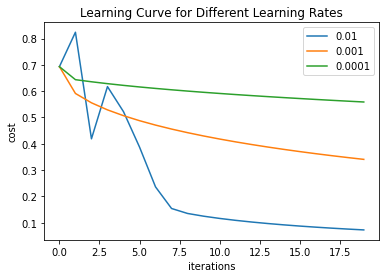

In [24]:
for learning_rate in learning_rates:
    model = models[str(learning_rate)]
    costs = model['costs']
    plt.plot(costs,  label= learning_rate)

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Learning Curve for Different Learning Rates')
plt.legend(loc='upper right')
plt.show()

## 5. Test our own images

### 5.1 single image 

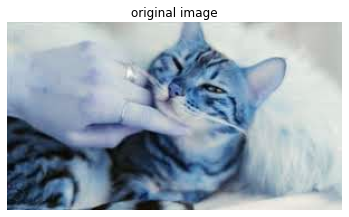

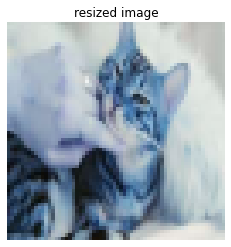

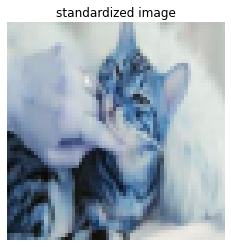

It is a cat picture according to prediction


In [29]:
test_image = os.path.join('test_data','cat01.jpeg')
test_image = cv2.imread(test_image)
plt.imshow(test_image)
plt.title('original image')
plt.axis('off')
plt.show()

test_image = cv2.resize(test_image, (num_px, num_px), interpolation=cv2.INTER_AREA)
plt.imshow(test_image)
plt.title('resized image')
plt.axis('off')
plt.show()

test_image = test_image / 255.
plt.imshow(test_image)
plt.title('standardized image')
plt.axis('off')
plt.show()

test_image = test_image.reshape(1, -1).T
y_pred = predict(d['w'], d['b'], test_image)
print('It is a %s picture according to prediction'%(classes[int(y_pred)].decode('utf-8')))



In [30]:
fns = os.listdir('test_data')
full_fns = []
for fn in fns:
    full_fns.append(os.path.join('test_data', fn))

(64, 64, 3)


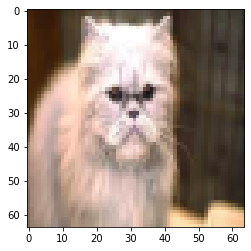

(64, 64, 3)


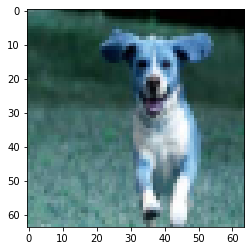

(64, 64, 3)


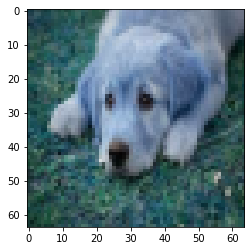

(64, 64, 3)


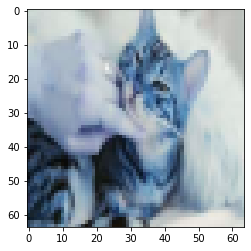

(12288, 4)


array([[0., 1., 0., 1.]])

In [31]:
test_images = []
for fn in full_fns:
    img = cv2.imread(fn)
    out = cv2.resize(img, (num_px, num_px), interpolation=cv2.INTER_AREA)
    print(out.shape)
    test_images.append(out)
    plt.imshow(out)
    plt.show()
test_images = np.array(test_images) / 255
test_X = test_images.reshape(test_images.shape[0], -1).T
print(test_X.shape)
predict(d['w'], d['b'], test_X)
